In [1]:
import pandas as pd
import numpy as np


from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler


from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [2]:
# функция для создания датасета со сдвигом для обучения модели(обеспечиваем сдвиг на 1 неделю вперед)
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    
    # входная последовательность (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
        
    # последовательность для прогноза (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
            
    # совмещаем
    agg = concat(cols, axis=1)
    agg.columns = names
    
    
    # выбрасываем строки с NaN значениями
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
def model_train(data, id_sku, lstm_neurons=10, lstm_epochs=75, lstm_batch_size=1):

    # выбрасываем ненужные колонки
    dataset = data.drop(['week_id', 'ID_SKU'], axis=1)
    values = dataset.values
    
    
    # переводим все данные в float Ддля надежности
    values = values.astype('float32')
    
    
    # нормализуем признаки
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    
    
    # формируем датасет со сдвигом(сдвиг равен 1 неделя в будущее для прогнозируемого параметра) для обучения
    reframed = series_to_supervised(scaled, 1, 1)
    
    
    # выбрасываем колонки, которые не нужны для обучения модели
    reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
    print(reframed.head())
    
    
    # разбиваем на датасеты для тренировки и для тестирования
    values = reframed.values
    
    test_size = 10
    train_size = len(values)-test_size
    train = values[:train_size, :]
    test = values[train_size:, :]
    

    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    
    
    
    # меняем размерность на трехмерную [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    
    # формируем модель
    model = Sequential()
    model.add(LSTM(lstm_neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
    
    model.add(Dense(1))
    
    
    keras.backend.set_epsilon(1)
    model.compile(loss='mae', optimizer='adam', metrics = 'mape')
    
    
    np.random.seed(7)
    
    # обучаем модель
    history = model.fit(train_X, train_y, epochs=lstm_epochs, batch_size=lstm_batch_size, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    
    
    # строим график Mape для обучения и тестирования
    pyplot.figure(figsize=(14,7))
    pyplot.plot(history.history['mape'], label='train')
    pyplot.plot(history.history['val_mape'], label='test')
    pyplot.legend()
    pyplot.show()
    
    
    # делаем прогноз
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    
    
    # инвертируем нормализацию получившегося прогноза
    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    
    
    # инвертируем нормализацию для фактических значений
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    
    
    # подсчет RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse)
    
    
    # формирование датасета для записи в эксель
    df_data = pd.DataFrame()
    
    df_data['ID_SKU'] = [id_sku for _ in range(train_X.shape[0]+1, train_X.shape[0]+1+test_size)]
    
    df_data['week_id'] = [i for i in range(train_X.shape[0]+1, train_X.shape[0]+1+test_size)]
    
    df_data['Forecast'] = inv_yhat
    
    df_data['Fact'] = inv_y
    
    df_data['ABS_Error'] = np.absolute(inv_yhat - inv_y)
    
    
    acc = 1 - np.sum(df_data['ABS_Error']) / np.sum(df_data['Fact'])
    
    df_data['Accuracy'] = [acc for _ in range(df_data.shape[0])]
    
    df_data.head(10)
    
    return df_data


In [4]:
# получаем список id_sku
df_sales_orig = pd.read_csv('sample.csv')
id_sku_names = df_sales_orig.ID_SKU.unique()

# загружаем датасеты для каждого id_sku и помещаем в список
data = []

for name in id_sku_names:
    data.append(pd.read_csv('df_sales_weeks_days_wide_final_id{}.csv'.format(name)))


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.223525   0.007075   0.355270   0.414005   0.450265   0.393507   
2   0.120247   0.355270   0.414005   0.450265   0.393507   0.353345   
3   0.037315   0.414005   0.450265   0.393507   0.353345   0.282697   
4   0.325778   0.450265   0.393507   0.353345   0.282697   0.392051   
5   0.016491   0.393507   0.353345   0.282697   0.392051   0.379305   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.353345   0.282697  0.120247  
2   0.282697   0.392051  0.037315  
3   0.392051   0.379305  0.325778  
4   0.379305   0.023463  0.016491  
5   0.023463   0.046769  0.054872  
(41, 1, 8) (41,) (10, 1, 8) (10,)
Epoch 1/75
41/41 - 1s - loss: 0.2290 - mape: 22.9047 - val_loss: 0.0894 - val_mape: 8.9379
Epoch 2/75
41/41 - 0s - loss: 0.2017 - mape: 20.1705 - val_loss: 0.0988 - val_mape: 9.8828
Epoch 3/75
41/41 - 0s - loss: 0.1965 - mape: 19.6467 - val_loss: 0.1007 - val_mape: 10.0727
Epoch 4/75
41/41 - 0s - loss: 0.1932 - mape: 19.3

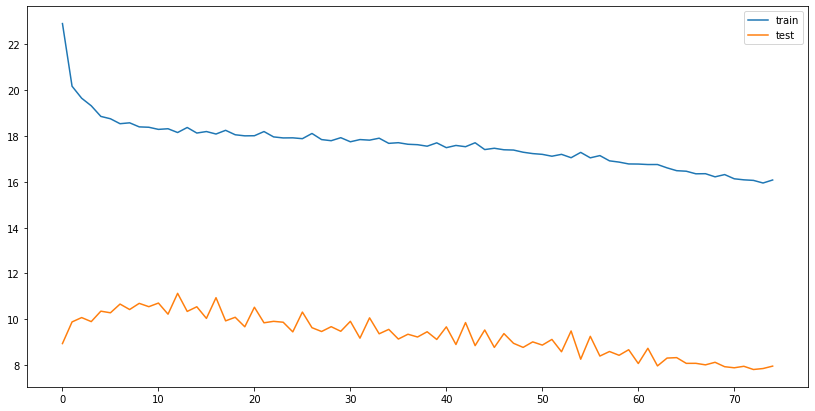

Test RMSE: 21320.886
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   1.000000   0.379119   0.737952   0.599901   0.898466   0.966749   
2   0.392293   0.737952   0.599901   0.898466   0.966749   1.000000   
3   0.187807   0.599901   0.898466   0.966749   1.000000   0.994755   
4   0.274104   0.898466   0.966749   1.000000   0.994755   0.990500   
5   0.288859   0.966749   1.000000   0.994755   0.990500   0.846808   

   var7(t-1)  var8(t-1)   var1(t)  
1   1.000000   1.000000  0.392293  
2   0.994755   0.995722  0.187807  
3   0.990500   0.851273  0.274104  
4   0.846808   0.000000  0.288859  
5   0.000000   0.040688  0.219917  
(41, 1, 8) (41,) (10, 1, 8) (10,)
Epoch 1/150
41/41 - 1s - loss: 0.2809 - mape: 28.0858 - val_loss: 0.1124 - val_mape: 11.2364
Epoch 2/150
41/41 - 0s - loss: 0.1726 - mape: 17.2610 - val_loss: 0.0617 - val_mape: 6.1732
Epoch 3/150
41/41 - 0s - loss: 0.1090 - mape: 10.8966 - val_loss: 0.0694 - val_mape: 6.9360
Epoch 4/150
41/41 - 0s - 

Epoch 83/150
41/41 - 0s - loss: 0.0575 - mape: 5.7477 - val_loss: 0.0553 - val_mape: 5.5286
Epoch 84/150
41/41 - 0s - loss: 0.0562 - mape: 5.6235 - val_loss: 0.0554 - val_mape: 5.5420
Epoch 85/150
41/41 - 0s - loss: 0.0563 - mape: 5.6276 - val_loss: 0.0553 - val_mape: 5.5349
Epoch 86/150
41/41 - 0s - loss: 0.0580 - mape: 5.7995 - val_loss: 0.0561 - val_mape: 5.6114
Epoch 87/150
41/41 - 0s - loss: 0.0572 - mape: 5.7206 - val_loss: 0.0558 - val_mape: 5.5786
Epoch 88/150
41/41 - 0s - loss: 0.0572 - mape: 5.7240 - val_loss: 0.0560 - val_mape: 5.6024
Epoch 89/150
41/41 - 0s - loss: 0.0561 - mape: 5.6069 - val_loss: 0.0561 - val_mape: 5.6060
Epoch 90/150
41/41 - 0s - loss: 0.0561 - mape: 5.6056 - val_loss: 0.0561 - val_mape: 5.6066
Epoch 91/150
41/41 - 0s - loss: 0.0556 - mape: 5.5605 - val_loss: 0.0561 - val_mape: 5.6071
Epoch 92/150
41/41 - 0s - loss: 0.0566 - mape: 5.6629 - val_loss: 0.0563 - val_mape: 5.6316
Epoch 93/150
41/41 - 0s - loss: 0.0556 - mape: 5.5584 - val_loss: 0.0562 - val_m

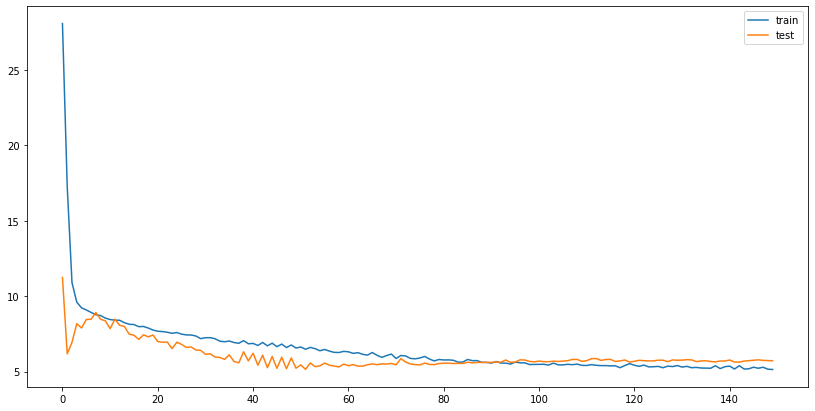

Test RMSE: 3441.194
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.627391   0.296580   0.384904   0.100592   0.437726   0.574253   
2   0.613854   0.384904   0.100592   0.437726   0.574253   0.749892   
3   0.259790   0.100592   0.437726   0.574253   0.749892   0.804589   
4   0.101977   0.437726   0.574253   0.749892   0.804589   0.807187   
5   0.521210   0.574253   0.749892   0.804589   0.807187   0.812671   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.749892   0.804589  0.613854  
2   0.804589   0.807187  0.259790  
3   0.807187   0.812671  0.101977  
4   0.812671   0.103045  0.521210  
5   0.103045   0.265551  0.219965  
(41, 1, 8) (41,) (10, 1, 8) (10,)
Epoch 1/40
41/41 - 1s - loss: 0.3416 - mape: 34.1605 - val_loss: 0.3641 - val_mape: 36.4111
Epoch 2/40
41/41 - 0s - loss: 0.2023 - mape: 20.2252 - val_loss: 0.1954 - val_mape: 19.5417
Epoch 3/40
41/41 - 0s - loss: 0.1703 - mape: 17.0315 - val_loss: 0.1496 - val_mape: 14.9558
Epoch 4/40
41/41 - 0s - los

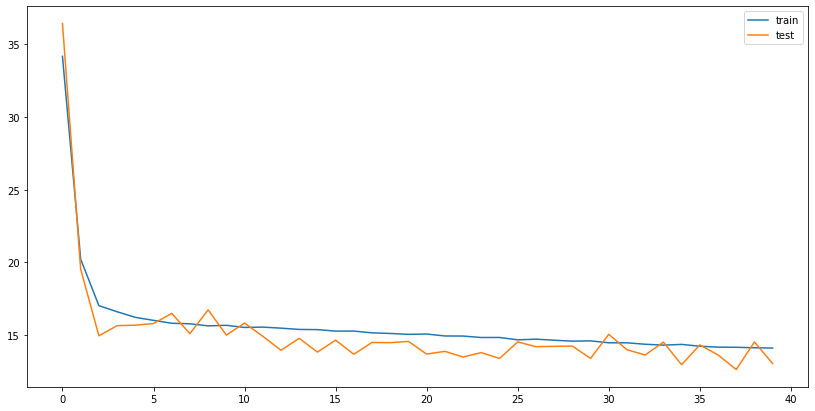

Test RMSE: 7501.001


In [5]:
df_data_final = pd.DataFrame()

# задаем параметры для каждой модели(так как стохастическая природа продаж для каждого id_sku разнится)
lstm_neurons = [10, 10, 10]

lstm_epochs= [75, 150, 40]

# обучаем
for df, id_sku, neurons, epochs in zip(data, id_sku_names, lstm_neurons, lstm_epochs):
    
    df_data = model_train(df, id_sku, neurons, epochs, lstm_batch_size=1)

    df_data_final = pd.concat([df_data_final, df_data], axis=0,sort=False)


df_data_final.to_excel("df_final.xlsx")